In [239]:
import json
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [240]:
FEATURES = pd.read_csv("NEW_FEATURES.csv")
FEATURES

,game_id,minute,minutes_remaining,week,final_score,team,opp_team_x,rolling_xg,opp_rolling_xg,rolling_pts,...,opp_goal_prob,team_wranking,opp_team_wranking,team_wranking_pts,opp_team_wranking_pts,is_home,pregame_winprob,opp_pregame_winprob,score_differential,player_differential
0,e3c3ddf0,1,94,1,4–3,Arsenal,Leicester City,0.0,0.0,0,...,0.031915,NaN,NaN,1935,1569,1,0.653595,0.153846,0,0
1,e3c3ddf0,1,94,1,4–3,Leicester City,Arsenal,0.0,0.0,0,...,0.042553,NaN,NaN,1569,1935,0,0.153846,0.653595,0,0
2,e3c3ddf0,2,93,1,4–3,Arsenal,Leicester City,0.0,0.0,0,...,0.032258,NaN,NaN,1935,1569,1,0.653595,0.153846,1,0
3,e3c3ddf0,2,93,1,4–3,Leicester City,Arsenal,0.0,0.0,0,...,0.032258,NaN,NaN,1569,1935,0,0.153846,0.653595,-1,0
4,e3c3ddf0,3,92,1,4–3,Arsenal,Leicester City,0.0,0.0,0,...,0.032609,NaN,NaN,1935,1569,1,0.653595,0.153846,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212269,a3f59c8e,89,2,38,1–1,Aston Villa,West Ham,3.6,5.9,7,...,0.000000,NaN,NaN,1772,1643,0,0.434783,0.333333,0,0
212270,a3f59c8e,90,1,38,1–1,West Ham,Aston Villa,5.9,3.6,7,...,0.000000,NaN,NaN,1643,1772,1,0.333333,0.434783,0,0
212271,a3f59c8e,90,1,38,1–1,Aston Villa,West Ham,3.6,5.9,7,...,0.000000,NaN,NaN,1772,1643,0,0.434783,0.333333,0,0
212272,a3f59c8e,91,0,38,1–1,West Ham,Aston Villa,5.9,3.6,7,...,0.000000,NaN,NaN,1643,1772,1,0.333333,0.434783,0,0


In [241]:
FEATURES.columns

Index(['game_id', 'minute', 'minutes_remaining', 'week', 'final_score', 'team',
       'opp_team_x', 'rolling_xg', 'opp_rolling_xg', 'rolling_pts',
       'opp_rolling_pts', 'goals', 'opp_goals', 'cumulative_xg',
       'opp_cumulative_xg', 'yellow_cards', 'opp_yellow_cards', 'red_cards',
       'opp_red_cards', 'goals_final', 'opp_goals_final', 'remaining_goals',
       'opp_remaining_goals', 'goal_prob', 'opp_goal_prob', 'team_wranking',
       'opp_team_wranking', 'team_wranking_pts', 'opp_team_wranking_pts',
       'is_home', 'pregame_winprob', 'opp_pregame_winprob',
       'score_differential', 'player_differential'],
      dtype='object')

In [307]:
features = ["rolling_pts", "opp_rolling_pts",
            "is_home", "week", "goals", "opp_goals", "score_differential", "cumulative_xg", 
            "opp_cumulative_xg", "yellow_cards", "opp_yellow_cards", "player_differential", 
            "pregame_winprob", "opp_pregame_winprob", 'team_wranking_pts', 'opp_team_wranking_pts']
target = "goal_prob"

In [308]:
print(len(FEATURES["game_id"].unique()))
1140 * 0.2

1140


228.0

In [309]:
# holdout_match_ids = ["e766e559"]
np.random.seed(2121)
holdout_match_ids = np.random.choice(FEATURES["game_id"].unique(), 10)
holdout_match_ids

array(['03da14dd', '09767606', '199aafa3', '111b8b45', 'b7a64fc3',
       '15c3f004', '1b4c17ec', '178a7528', '0d60e1e4', '21cbea56'],
      dtype=object)

In [310]:
holdout_mask = FEATURES["game_id"].isin(holdout_match_ids)
dataset = FEATURES[~holdout_mask]
dataset

,game_id,minute,minutes_remaining,week,final_score,team,opp_team_x,rolling_xg,opp_rolling_xg,rolling_pts,...,opp_goal_prob,team_wranking,opp_team_wranking,team_wranking_pts,opp_team_wranking_pts,is_home,pregame_winprob,opp_pregame_winprob,score_differential,player_differential
0,e3c3ddf0,1,94,1,4–3,Arsenal,Leicester City,0.0,0.0,0,...,0.031915,NaN,NaN,1935,1569,1,0.653595,0.153846,0,0
1,e3c3ddf0,1,94,1,4–3,Leicester City,Arsenal,0.0,0.0,0,...,0.042553,NaN,NaN,1569,1935,0,0.153846,0.653595,0,0
2,e3c3ddf0,2,93,1,4–3,Arsenal,Leicester City,0.0,0.0,0,...,0.032258,NaN,NaN,1935,1569,1,0.653595,0.153846,1,0
3,e3c3ddf0,2,93,1,4–3,Leicester City,Arsenal,0.0,0.0,0,...,0.032258,NaN,NaN,1569,1935,0,0.153846,0.653595,-1,0
4,e3c3ddf0,3,92,1,4–3,Arsenal,Leicester City,0.0,0.0,0,...,0.032609,NaN,NaN,1935,1569,1,0.653595,0.153846,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212269,a3f59c8e,89,2,38,1–1,Aston Villa,West Ham,3.6,5.9,7,...,0.000000,NaN,NaN,1772,1643,0,0.434783,0.333333,0,0
212270,a3f59c8e,90,1,38,1–1,West Ham,Aston Villa,5.9,3.6,7,...,0.000000,NaN,NaN,1643,1772,1,0.333333,0.434783,0,0
212271,a3f59c8e,90,1,38,1–1,Aston Villa,West Ham,3.6,5.9,7,...,0.000000,NaN,NaN,1772,1643,0,0.434783,0.333333,0,0
212272,a3f59c8e,91,0,38,1–1,West Ham,Aston Villa,5.9,3.6,7,...,0.000000,NaN,NaN,1643,1772,1,0.333333,0.434783,0,0


In [311]:
X_train, X_test, y_train, y_test = train_test_split(dataset[features], 
                                                    dataset[target], 
                                                    test_size=0.2, random_state=21)

X_train.shape, X_test.shape

((168324, 17), (42082, 17))

In [312]:
model = lgb.LGBMRegressor()

In [313]:
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 168324, number of used features: 17
[LightGBM] [Info] Start training from score 0.016805


LGBMRegressor()

In [314]:
predictions = model.predict(X_test)

In [315]:
predictions = np.maximum(0, predictions)
predictions

array([0.01172189, 0.01205153, 0.01472527, ..., 0.01399265, 0.02031172,
       0.01067737])

In [316]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"MSE: {mse}\nR2: {r2}")

MSE: 0.0011738662434968364
R2: 0.3007352483280038


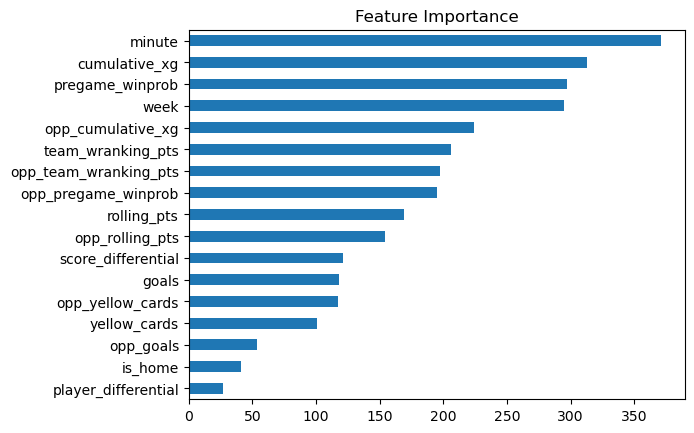

In [317]:
(pd.Series(model.feature_importances_, index=features)
 .sort_values()
   .plot(kind='barh', title='Feature Importance'));

In [318]:
holdouts = FEATURES[holdout_mask]
holdouts

,game_id,minute,minutes_remaining,week,final_score,team,opp_team_x,rolling_xg,opp_rolling_xg,rolling_pts,...,opp_goal_prob,team_wranking,opp_team_wranking,team_wranking_pts,opp_team_wranking_pts,is_home,pregame_winprob,opp_pregame_winprob,score_differential,player_differential
14704,199aafa3,1,93,8,1–1,Leicester City,West Brom,4.7,3.5,2,...,0.010753,NaN,NaN,1569,1478,1,0.487805,0.238095,0,0
14705,199aafa3,1,93,8,1–1,West Brom,Leicester City,3.5,4.7,2,...,0.010753,NaN,NaN,1478,1569,0,0.238095,0.487805,0,0
14706,199aafa3,2,92,8,1–1,Leicester City,West Brom,4.7,3.5,2,...,0.010870,NaN,NaN,1569,1478,1,0.487805,0.238095,0,0
14707,199aafa3,2,92,8,1–1,West Brom,Leicester City,3.5,4.7,2,...,0.010870,NaN,NaN,1478,1569,0,0.238095,0.487805,0,0
14708,199aafa3,3,91,8,1–1,Leicester City,West Brom,4.7,3.5,2,...,0.010989,NaN,NaN,1569,1478,1,0.487805,0.238095,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207591,21cbea56,89,2,36,1–3,Tottenham,Newcastle Utd,3.0,3.0,7,...,0.000000,NaN,NaN,1760,1786,0,0.571429,0.217391,1,0
207592,21cbea56,90,1,36,1–3,Newcastle Utd,Tottenham,3.0,3.0,1,...,0.000000,NaN,NaN,1786,1760,1,0.217391,0.571429,-2,0
207593,21cbea56,90,1,36,1–3,Tottenham,Newcastle Utd,3.0,3.0,7,...,0.000000,NaN,NaN,1760,1786,0,0.571429,0.217391,2,0
207594,21cbea56,91,0,36,1–3,Newcastle Utd,Tottenham,3.0,3.0,1,...,0.000000,NaN,NaN,1786,1760,1,0.217391,0.571429,-2,0


In [319]:
[z for z in holdout_match_ids]

['03da14dd',
 '09767606',
 '199aafa3',
 '111b8b45',
 'b7a64fc3',
 '15c3f004',
 '1b4c17ec',
 '178a7528',
 '0d60e1e4',
 '21cbea56']

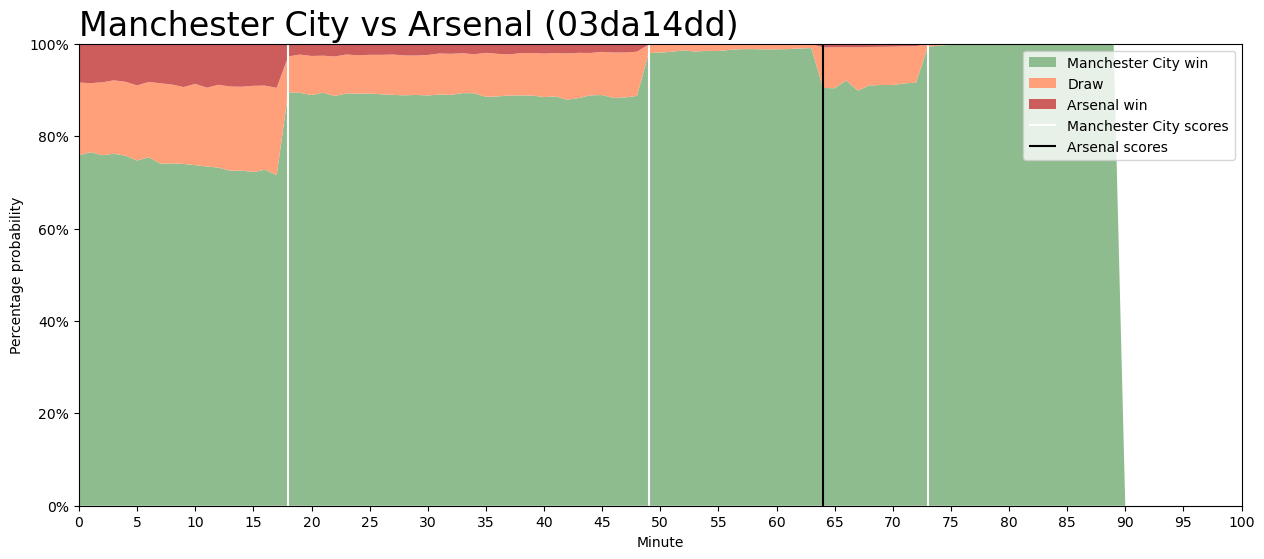

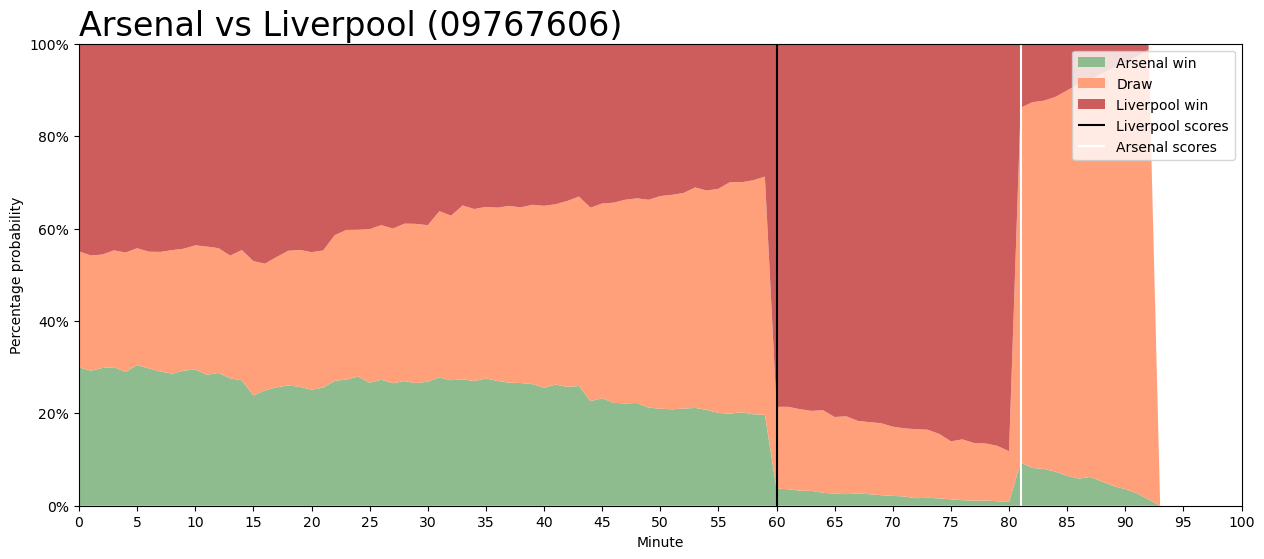

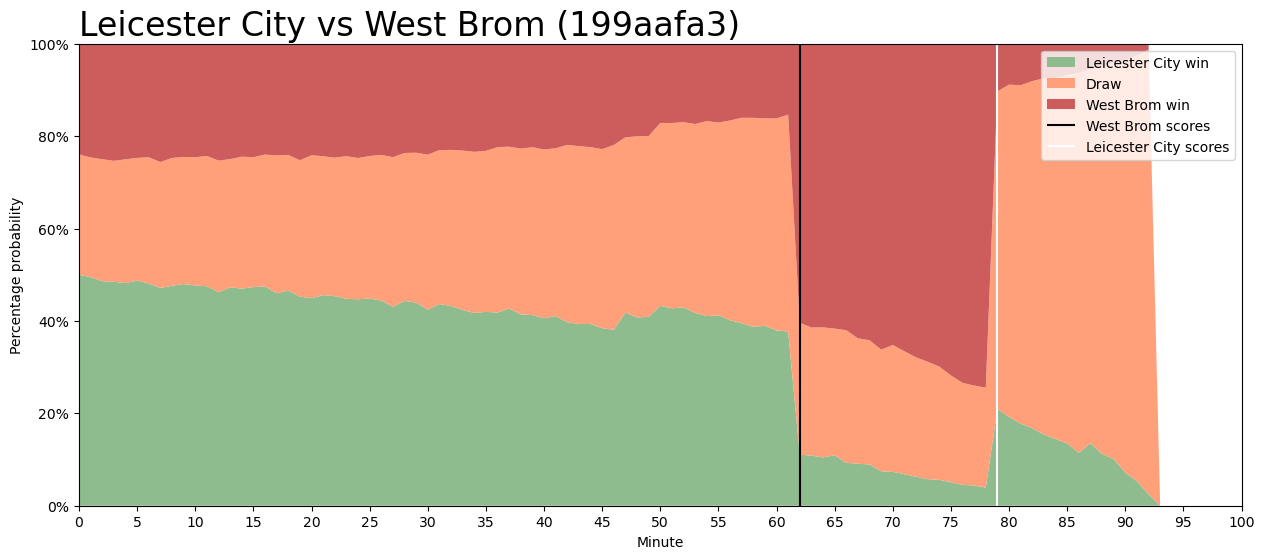

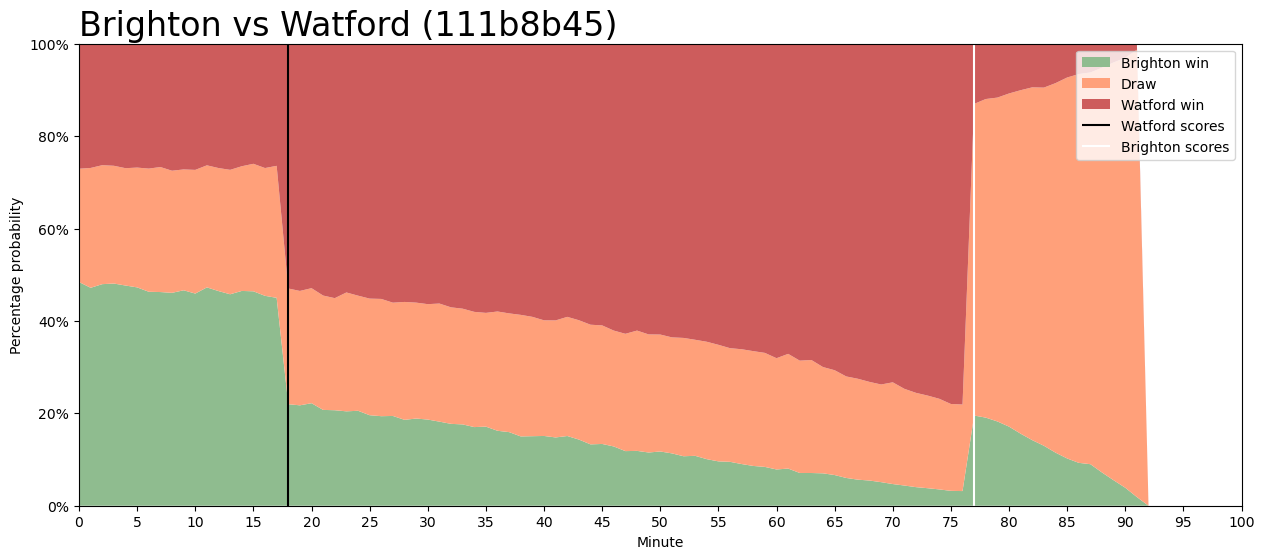

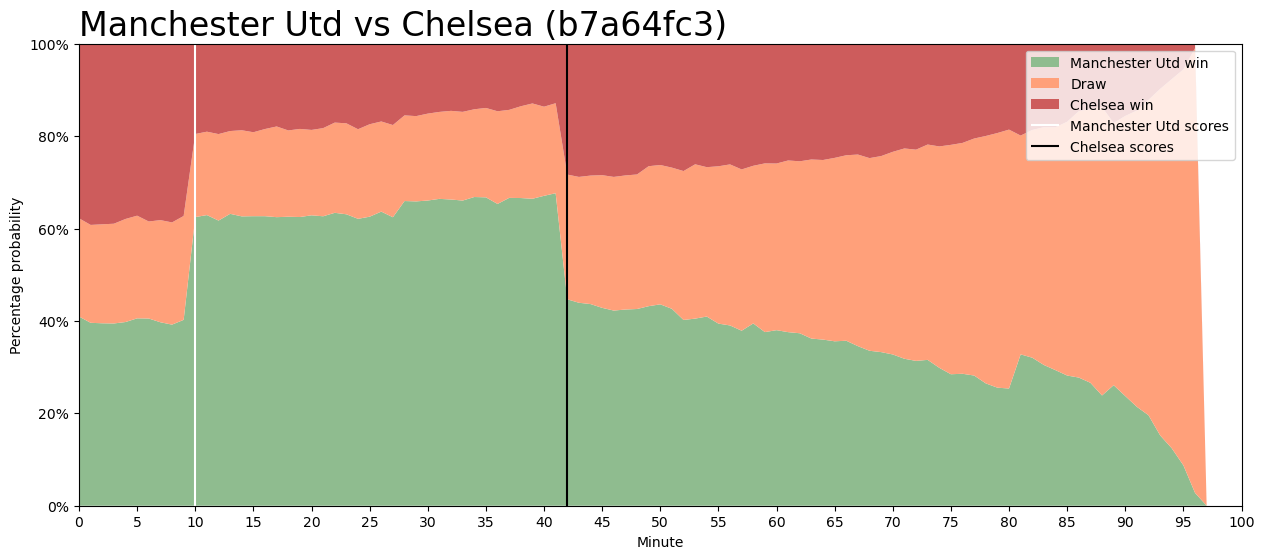

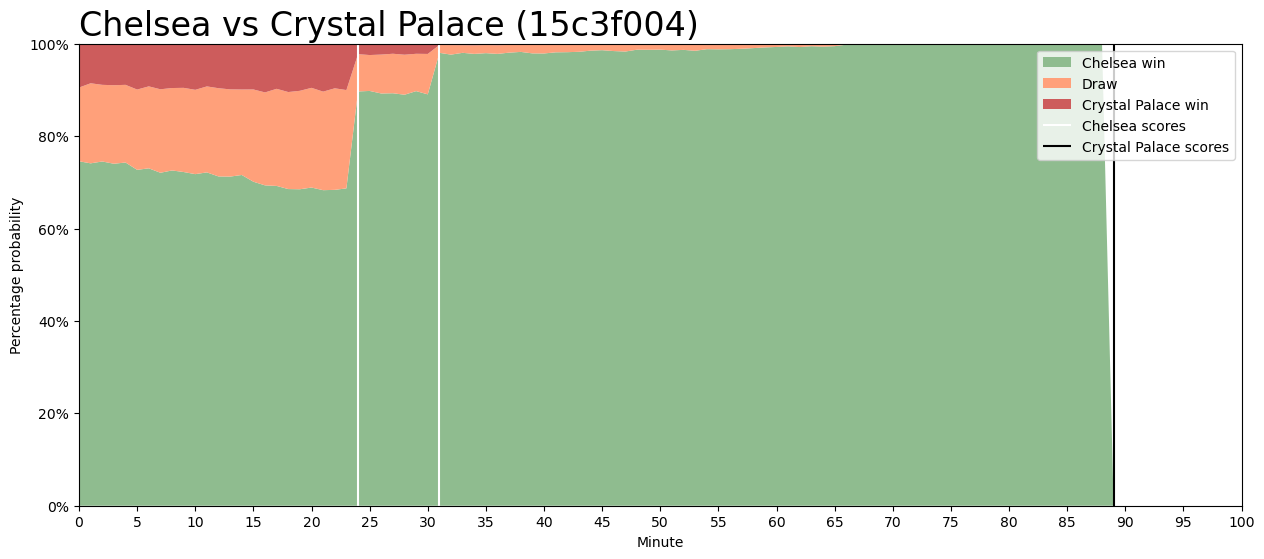

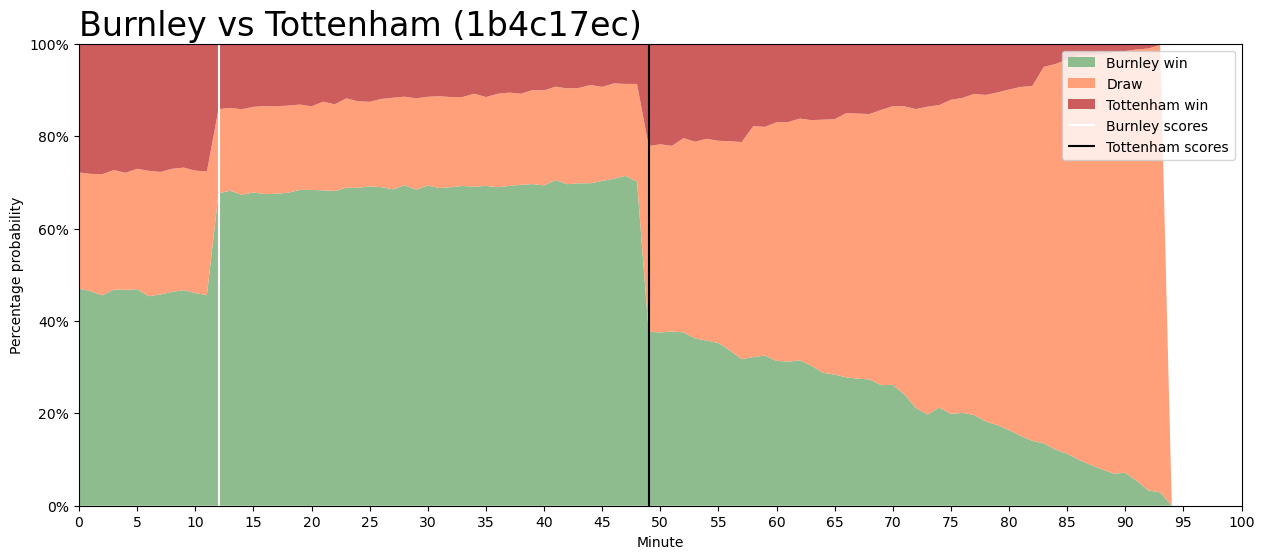

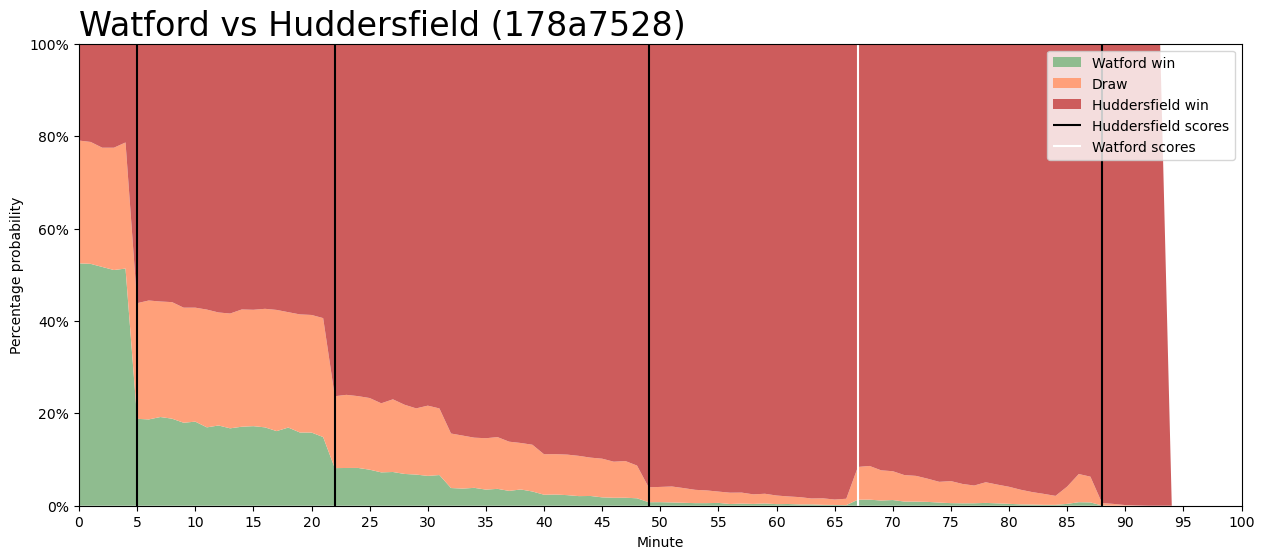

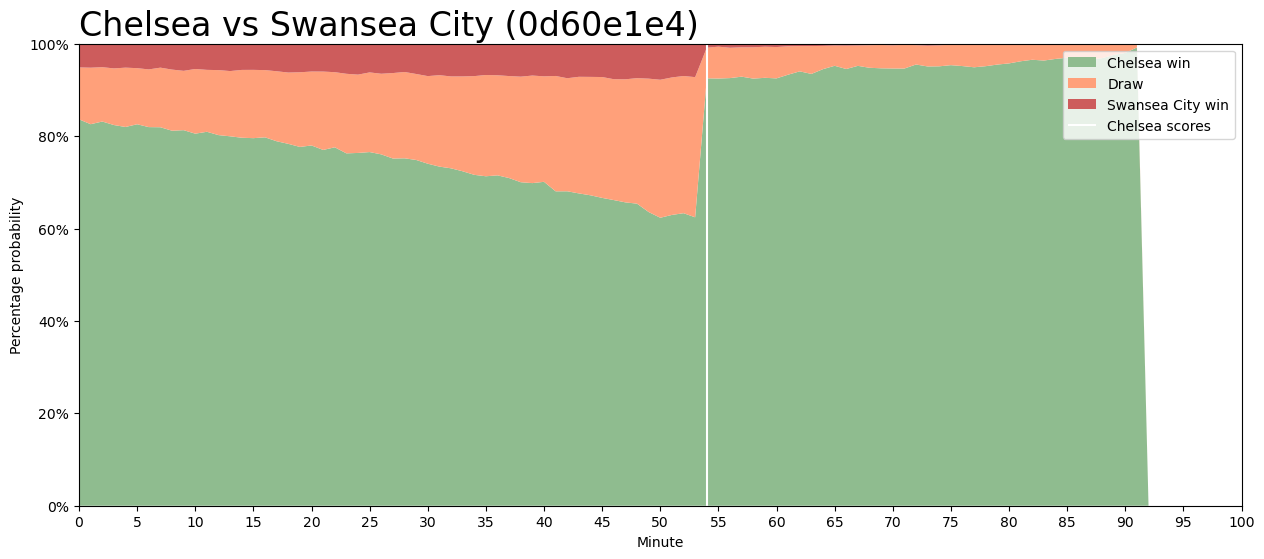

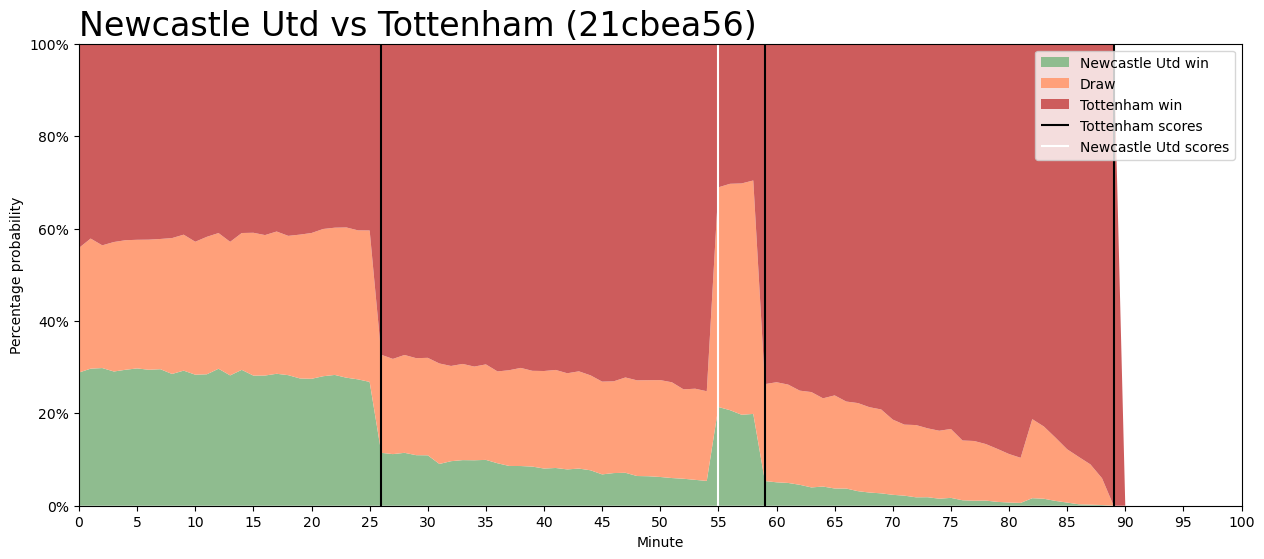

In [320]:
n_sims = 10000
# fig, axes = plt.subplots(figsize=(15, 6), sharey=True)

for holdout_match_id in holdout_match_ids:

    fig, ax = plt.subplots(figsize=(15, 6))

    holdout = FEATURES.query("game_id == @holdout_match_id").copy()
    holdout["goal_prob"] = model.predict(holdout[features])

    home_team = holdout.query("is_home == 1").team.unique()[0]
    away_team = holdout.query("is_home == 0").team.unique()[0]

    h = holdout.pivot_table(index='minute', 
                            columns='team', 
                            values=['goal_prob', 'score_differential']).reset_index()
    h.columns = [a+"_"+str(b) for (a,b) in h.columns]
    h = h.reset_index(drop=True)

    for idx in h[h.isnull().any(axis=1)].index:
        if h.loc[idx, f"score_differential_{home_team}"] != h.loc[idx, f"score_differential_{home_team}"]:
            h.loc[idx, f"score_differential_{home_team}"] = -h.loc[idx, f"score_differential_{away_team}"]
            
        elif h.loc[idx, f"score_differential_{away_team}"] != h.loc[idx, f"score_differential_{away_team}"]:
            h.loc[idx, f"score_differential_{away_team}"] = -h.loc[idx, f"score_differential_{home_team}"]

    h = h.fillna(0)
    home_wins_list = []
    away_wins_list = []
    draws_list = []
    max_min = h["minute_"].max()

    for minute, hsd, asd, h_prob, a_prob in zip(h["minute_"], 
                                               h[f"score_differential_{home_team}"], 
                                               h[f"score_differential_{away_team}"], 
                                               h[f"goal_prob_{home_team}"], 
                                               h[f"goal_prob_{away_team}"]):
        if minute != max_min:

            home_goals_sim = np.random.binomial(max_min - minute, h_prob, n_sims)
            away_goals_sim = np.random.binomial(max_min - minute, a_prob, n_sims)
            
            home_sd_sim = hsd + (home_goals_sim - away_goals_sim)

            home_wins = np.sum(home_sd_sim > 0)
            away_wins = np.sum(home_sd_sim < 0)
            draws = np.sum(home_sd_sim == 0)

            home_wins_list.append((home_wins/n_sims)*100)
            away_wins_list.append((away_wins/n_sims)*100)
            draws_list.append((draws/n_sims)*100)
            
        else:
            
            home_wins_list.append(0)
            away_wins_list.append(0)
            draws_list.append(0)

    y = np.vstack([home_wins_list, draws_list, away_wins_list])
    
    ax.stackplot(range(len(home_wins_list)), 
                 y, 
                 labels=[f"{home_team} win", "Draw", f"{away_team} win"], 
                 colors=["darkseagreen", "lightsalmon", "indianred"]
                )
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    draw_home_goals = draw_away_goals = True

    for (idx, val) in h.loc[(h[f"score_differential_{home_team}"].diff()!=0), f"score_differential_{home_team}"].diff().dropna().items():
        if val == 1:
            if draw_home_goals:
                draw_home_goals = False
                hlabel = f"{home_team} scores"
            else:
                hlabel = None
            ax.vlines(idx, 0, 100, color=['white'], label=hlabel)
        elif val == -1:
            if draw_away_goals:
                alabel = f"{away_team} scores"
                draw_away_goals = False
            else:
                alabel = None
            ax.vlines(idx, 0, 100, color=['black'], label=alabel)
    
    ## plot cosmetics
    
    ax.set(xlabel = "Minute", 
           ylabel= "Percentage probability",
           xlim=(0, len(home_wins_list)),
           ylim=(0, 100))
    plt.xticks(np.arange(0, 101, 5))
    
    ax.title.set(text=f"{home_team} vs {away_team} ({holdout_match_id})",
                 fontsize=24, x=0, ha='left')

    ax.legend(loc=1);
    plt.show()
    # fig.savefig('test', dpi=200)

#fig.show()

In [139]:
y

array([[7.064e+01, 6.982e+01, 6.991e+01, 6.907e+01, 6.876e+01, 8.787e+01,
        8.817e+01, 8.741e+01, 8.756e+01, 8.750e+01, 8.765e+01, 8.777e+01,
        8.840e+01, 9.816e+01, 9.809e+01, 9.782e+01, 9.800e+01, 9.774e+01,
        9.967e+01, 9.970e+01, 9.956e+01, 9.966e+01, 9.966e+01, 9.962e+01,
        9.970e+01, 9.954e+01, 9.959e+01, 9.970e+01, 9.948e+01, 9.961e+01,
        9.957e+01, 9.960e+01, 9.968e+01, 9.967e+01, 9.961e+01, 9.960e+01,
        9.994e+01, 9.999e+01, 9.995e+01, 9.998e+01, 9.992e+01, 9.996e+01,
        9.994e+01, 9.999e+01, 9.996e+01, 9.998e+01, 9.998e+01, 9.999e+01,
        1.000e+02, 9.999e+01, 9.998e+01, 9.993e+01, 9.990e+01, 9.993e+01,
        9.994e+01, 1.000e+02, 9.999e+01, 9.998e+01, 9.998e+01, 1.000e+02,
        9.999e+01, 1.000e+02, 1.000e+02, 9.999e+01, 9.997e+01, 1.000e+02,
        9.999e+01, 9.999e+01, 9.999e+01, 9.999e+01, 9.999e+01, 1.000e+02,
        1.000e+02, 1.000e+02, 1.000e+02, 1.000e+02, 1.000e+02, 1.000e+02,
        1.000e+02, 1.000e+02, 1.000e+0

In [279]:
arsnor = FEATURES[FEATURES["game_id"] == holdout_match_ids[3]]
arsnor

,game_id,minute,minutes_remaining,week,final_score,team,opp_team_x,rolling_xg,opp_rolling_xg,rolling_pts,...,opp_goal_prob,team_wranking,opp_team_wranking,team_wranking_pts,opp_team_wranking_pts,is_home,pregame_winprob,opp_pregame_winprob,score_differential,player_differential
68348,90f41993,1,95,31,1–0,Tottenham,Newcastle Utd,3.9,3.3,4,...,0.000000,NaN,NaN,1760,1786,1,0.847458,0.058824,0,0
68349,90f41993,1,95,31,1–0,Newcastle Utd,Tottenham,3.3,3.9,0,...,0.010526,NaN,NaN,1786,1760,0,0.058824,0.847458,0,0
68350,90f41993,2,94,31,1–0,Tottenham,Newcastle Utd,3.9,3.3,4,...,0.000000,NaN,NaN,1760,1786,1,0.847458,0.058824,0,0
68351,90f41993,2,94,31,1–0,Newcastle Utd,Tottenham,3.3,3.9,0,...,0.010638,NaN,NaN,1786,1760,0,0.058824,0.847458,0,0
68352,90f41993,3,93,31,1–0,Tottenham,Newcastle Utd,3.9,3.3,4,...,0.000000,NaN,NaN,1760,1786,1,0.847458,0.058824,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68535,90f41993,94,2,31,1–0,Newcastle Utd,Tottenham,3.3,3.9,0,...,0.000000,NaN,NaN,1786,1760,0,0.058824,0.847458,-1,0
68536,90f41993,95,1,31,1–0,Tottenham,Newcastle Utd,3.9,3.3,4,...,0.000000,NaN,NaN,1760,1786,1,0.847458,0.058824,1,0
68537,90f41993,95,1,31,1–0,Newcastle Utd,Tottenham,3.3,3.9,0,...,0.000000,NaN,NaN,1786,1760,0,0.058824,0.847458,-1,0
68538,90f41993,96,0,31,1–0,Tottenham,Newcastle Utd,3.9,3.3,4,...,0.000000,NaN,NaN,1760,1786,1,0.847458,0.058824,1,0


In [280]:
arsnor[(arsnor["minute"].isin(list(range(24, 32)))) & (arsnor["is_home"] == 1)][features]

,rolling_pts,opp_rolling_pts,is_home,goals,opp_goals,score_differential,cumulative_xg,opp_cumulative_xg,yellow_cards,opp_yellow_cards,player_differential,pregame_winprob,opp_pregame_winprob,team_wranking_pts,opp_team_wranking_pts
68394,4,0,1,0,0,0,0.07,0.27,0,0,0,0.847458,0.058824,1760,1786
68396,4,0,1,0,0,0,0.11,0.27,0,0,0,0.847458,0.058824,1760,1786
68398,4,0,1,0,0,0,0.11,0.27,0,0,0,0.847458,0.058824,1760,1786
68400,4,0,1,0,0,0,0.11,0.33,0,0,0,0.847458,0.058824,1760,1786
68402,4,0,1,0,0,0,0.11,0.33,0,0,0,0.847458,0.058824,1760,1786
68404,4,0,1,0,0,0,0.11,0.47,0,0,0,0.847458,0.058824,1760,1786
68406,4,0,1,0,0,0,0.11,0.47,0,0,0,0.847458,0.058824,1760,1786
68408,4,0,1,0,0,0,0.11,0.47,0,0,0,0.847458,0.058824,1760,1786


In [275]:
list(range(55, 67))

[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]